In [84]:
from collections import Counter
from itertools import product
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib
matplotlib.rc('pdf', fonttype=42)
matplotlib.rc('font', **{'size': 14})
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('ticks')

# load dataset

In [2]:
figure_path = 'D:\HanWuLove\wh_wayfair_babson_hackathon2021\plots'
data_path = 'D:\HanWuLove\wh_wayfair_babson_hackathon2021\data'

In [17]:
df_past = pd.read_csv(os.path.join(data_path, 'Customer In Stock Dataset Final.csv'), encoding='ISO-8859-1')
df_forward = pd.read_csv(os.path.join(data_path, 'Forward Coverage Dataset Final.csv'), encoding='ISO-8859-1')

df_past = df_past.rename(columns={
    'CustomerInstock_Denom':'Demand',
    'CustomerInstock_Num':'CoveredSales',
    'WholesaleCostNoRebates':'WholesaleCost'})

df_past['MissedDemand'] = df_past.WH_LostSales_OOS + df_past.DS_LostSales_OOS
df_past['InStockPerc'] = df_past.CoveredSales / df_past.Demand*100
df_past['L2marker'] = [np.nan]*len(df_past)
df_past['FCR_Type'] = [np.nan]*len(df_past)
df_past['qty_fulfilled_oh'] = [np.nan]*len(df_past)
df_past['qty_fulfilled_oo'] = [np.nan]*len(df_past)
df_past['qty_fulfilled_if'] = [np.nan]*len(df_past)
df_past['qty_fulfilled_l2'] = [np.nan]*len(df_past)
df_past['FromForward'] = [0]*len(df_past)

df_forward = df_forward.rename(columns={'Forecast':'Demand'})
df_forward['CoveredSales'] = df_forward[['qty_fulfilled_oh', 'qty_fulfilled_oo', 'qty_fulfilled_if', 'qty_fulfilled_l2']].sum(axis=1)
df_forward['MissedDemand'] = df_forward.Demand - df_forward.CoveredSales
df_forward['InStockPerc'] = df_forward.CoveredSales / df_forward.Demand*100
df_forward['L2marker'] = df_forward.FCR_Type.astype(str).str.lower().str.contains('l2').astype(int)
df_forward['FromForward'] = [1]*len(df_forward)

cols = ['FromForward', 'Date', 'SKU', 'suid', 'ItemMarketingCategory', 'ItemClass', 'Country', 'ItemShipClass', 'WholesaleCost', 'Demand', 'CoveredSales', 'MissedDemand', 'InStockPerc', 'L2marker', 'FCR_Type', 'qty_fulfilled_oh', 'qty_fulfilled_oo', 'qty_fulfilled_if', 'qty_fulfilled_l2']
df = pd.concat([df_past[cols], df_forward[cols]], axis=0, ignore_index=True)

exclude_cols_past = [x for x in df_past.columns if x not in cols]
exclude_cols_forward = [x for x in df_forward.columns if x not in cols]
print(f'excluded past cols: {exclude_cols_past}')
print(f'excluded forward cols: {exclude_cols_forward}')

"""
excluded past cols: ['DateType', 'WH_CustomerInstock_Num', 'WH_CustomerInstock_Denom', 'Distributor_CustomerInstock_Num', 'Distributor_CustomerInstock_Denom', 'WH_LostSales_OOS', 'DS_LostSales_OOS']
excluded forward cols: ['DateType', 'FCR_Type', 'qty_fulfilled_oh', 'qty_fulfilled_oo', 'qty_fulfilled_if', 'qty_fulfilled_l2']
"""

ids = df.WholesaleCost>0  # positive and not empty
ids &= df.Demand>0   # positive and not empty
df2 = df[ids].reset_index(drop=True)
#df2.to_csv(os.path.join(data_path, 'combined_dataset_0325.csv'), index=False)

excluded past cols: ['DateType', 'WH_CustomerInstock_Num', 'WH_CustomerInstock_Denom', 'Distributor_CustomerInstock_Num', 'Distributor_CustomerInstock_Denom', 'WH_LostSales_OOS', 'DS_LostSales_OOS']
excluded forward cols: ['DateType']


In [18]:
df2 = df2[(df2.FromForward==1)&(df2.Country=='United States')].reset_index(drop=True)
df2 = df2.drop(columns=['FromForward', 'Country', 'MissedDemand', 'InStockPerc'])
df2['NoL2marker'] = 1-df2.L2marker

In [19]:
df3 = df2.groupby(['Date', 'SKU', 'suid', 'ItemMarketingCategory', 'ItemClass', 'ItemShipClass']).agg({
    'L2marker':'sum',
    'NoL2marker':'sum',
    'WholesaleCost':'mean',
    'Demand':'max',
    'CoveredSales':'sum',
    'qty_fulfilled_oh':'sum',
    'qty_fulfilled_oo':'sum',
    'qty_fulfilled_if':'sum',
    'qty_fulfilled_l2':'sum'})
df3['MissedDemand'] = df3.Demand - df3.CoveredSales
df3['InStockPerc'] = df3.CoveredSales / df3.Demand*100
df3['DemandCount'] = df3.Demand / df3.WholesaleCost
df3['MissedCount'] = df3.MissedDemand/df3.WholesaleCost

df3 = df3[['L2marker', 'NoL2marker',
   'WholesaleCost', 'Demand', 'CoveredSales', 'MissedDemand', 'DemandCount', 'MissedCount', 'InStockPerc',
   'qty_fulfilled_oh', 'qty_fulfilled_oo', 'qty_fulfilled_if',
   'qty_fulfilled_l2']]
#df3.to_csv(os.path.join(data_path, 'combined_dataset_aggregated_0325.csv'))
df3 = df3.reset_index()

In [20]:
df3 = df3[df3.MissedDemand>0].reset_index(drop=True) # use positive missed demand
unique_dates = df3.Date.unique()
unique_categories = df3.ItemMarketingCategory.unique()
print(len(unique_dates), unique_dates)
print(len(unique_categories), unique_categories)

12 ['2020-09-01' '2020-10-01' '2020-11-01' '2020-12-01' '2021-01-01'
 '2021-02-01' '2021-03-01' '2021-04-01' '2021-05-01' '2021-06-01'
 '2021-07-01' '2021-08-01']
47 ['Upholstery - Niche' 'Storage and Org' 'Small Electrics' 'Food Service'
 'Fireplaces & Grills' 'Decorative Accents' 'Furniture - Home Office'
 'Outdoor Structures & Spa' 'Education' 'Upholstery - Core' 'Recreation'
 'Kitchen' 'Lighting' 'AV' 'Accent Furniture' 'Pet'
 'Furniture - Kitchen and Dining' 'Entertainment Furniture' 'Outdoor'
 'Furniture - Bedroom' 'Youth Bedroom' 'Plumbing - Core' 'Outdoor Decor'
 'Tabletop' 'Hardware' 'Flooring' 'Bedding' 'Rugs' 'Playroom' 'Nursery'
 'Wall Art' 'Plumbing - Vanities' 'Mattresses' 'Appliances'
 'Seasonal Decor' 'Office' 'Window' 'Mattresses - Utility Bedding' 'Bath'
 'Accommodations' 'Commercial Renovation' 'Health & Fitness' 'Teen'
 'Unknown' 'Wayfair' 'Office Supplies' 'Power Equipment']


In [25]:
mu = np.mean(df3.WholesaleCost)
print(f'mu = {mu}')
print(f'% lower than mu = {np.mean(df3.WholesaleCost < mu)}')
print(f'% higher than mu = {np.mean(df3.WholesaleCost > mu)}')

median = np.median(df3.WholesaleCost)
print(f'median = {median}')
print(f'% lower than median = {np.mean(df3.WholesaleCost < median)}')
print(f'% higher than median = {np.mean(df3.WholesaleCost > median)}')
print('Small: <median. Medium: median to mean. ')

mu = 191.6716188172838
% lower than mu = 0.735721349584516
% higher than mu = 0.264278650415484
median = 77.5
% lower than median = 0.4994798422830429
% higher than median = 0.4994367251530658
Small: <median. Medium: median to mean. 


In [26]:
mu = np.mean(df3.MissedCount)
print(f'mu = {mu}')
print(f'% lower than mu = {np.mean(df3.MissedCount < mu)}')
print(f'% higher than mu = {np.mean(df3.MissedCount > mu)}')

median = np.median(df3.MissedCount)
print(f'median = {median}')
print(f'% lower than median = {np.mean(df3.MissedCount < median)}')
print(f'% higher than median = {np.mean(df3.MissedCount > median)}')
print('Small: <median. Medium: median to mean. Large: >mean')

mu = 1.1117050582916386
% lower than mu = 0.8558539301722667
% higher than mu = 0.14414606982773331
median = 0.19286667939400004
% lower than median = 0.5
% higher than median = 0.5
Small: <median. Medium: median to mean. Large: >mean


## Replenishment Pool

### 1. Classify Categories by cost

In [27]:
unique_categories = df3.ItemMarketingCategory.unique()

mus = []
medians = []
for category in unique_categories:
    mus.append(np.mean(df3.WholesaleCost[df3.ItemMarketingCategory==category]))
    medians.append(np.median(df3.WholesaleCost[df3.ItemMarketingCategory==category]))

df_cat = pd.DataFrame(data={'Category':unique_categories, 'mu':mus, 'median':medians})
df_cat = df_cat.sort_values('median', ascending=False).reset_index(drop=True)

150.775
['Plumbing - Vanities' 'Youth Bedroom' 'Upholstery - Core' 'Mattresses'
 'Upholstery - Niche' 'Outdoor' 'Furniture - Bedroom'
 'Furniture - Kitchen and Dining' 'Appliances']
84.93124999999999
['Accent Furniture' 'Rugs' 'Entertainment Furniture'
 'Furniture - Home Office' 'Plumbing - Core' 'Outdoor Structures & Spa'
 'Fireplaces & Grills' 'Food Service' 'Teen']
['Wall Art' 'Office' 'Power Equipment' 'Lighting' 'Recreation' 'Pet'
 'Unknown' 'AV' 'Playroom' 'Small Electrics' 'Education'
 'Mattresses - Utility Bedding' 'Hardware' 'Storage and Org'
 'Decorative Accents' 'Flooring' 'Bath' 'Bedding' 'Window'
 'Commercial Renovation' 'Seasonal Decor' 'Health & Fitness'
 'Outdoor Decor' 'Accommodations' 'Kitchen' 'Nursery' 'Tabletop'
 'Office Supplies' 'Wayfair']


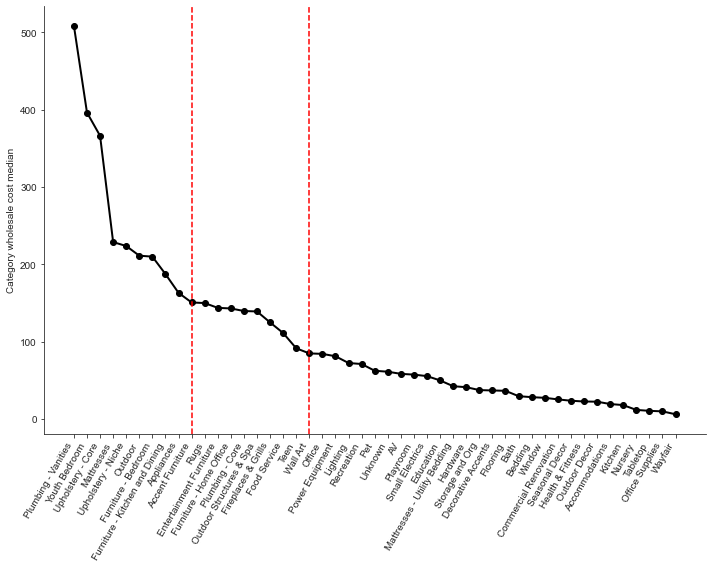

In [33]:
from kneed import KneeLocator
x = np.arange(len(df_cat))
y = df_cat['median'].values
kl = KneeLocator(x, y, curve="convex", direction="decreasing")
knee1 = kl.knee
print(y[knee1])
print(df_cat.Category.iloc[:knee1].values)

kl = KneeLocator(x[knee1:], y[knee1:], curve="convex", direction="decreasing")
knee2 = knee1+kl.knee
print(y[knee2])
print(df_cat.Category.iloc[knee1:knee2].values)
print(df_cat.Category.iloc[knee2:].values)

plt.close()
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(x, y, lw=2, marker='o', c='k')
ax.axvline(knee1, ls='--', c='r')
ax.axvline(knee2, ls='--', c='r')
ax.set_xticks(x)
ax.set_xticklabels(df_cat.Category, rotation=60, ha="right")
ax.set_ylabel('Category wholesale cost median')
seaborn.despine()
plt.tight_layout()

In [34]:
high_categories = unique_categories[:knee1]
medium_categories = unique_categories[knee1:knee2]
low_categories = unique_categories[knee2:]

cc = np.zeros(len(df3), dtype=object)
cc[np.in1d(df3.ItemMarketingCategory, high_categories)] = 'high'
cc[np.in1d(df3.ItemMarketingCategory, medium_categories)] = 'medium'
cc[np.in1d(df3.ItemMarketingCategory, low_categories)] = 'low'
df3['CostCategory'] = cc

### 2.Drop off unpropsal demand <= 1

In [35]:
print(np.mean(df3.MissedCount<=1))  # proportion of MissedCount<=1 in df3
df4 = df3[df3.MissedCount<=1].reset_index(drop=True)
print(df4.MissedDemand.sum() / df3.MissedDemand.sum())  # proportion of missed demand in MissedCount<=1
df4.to_csv(os.path.join(data_path, 'substitution.csv'))  # used as substitution pool

0.8411867668941172
0.25040293421984056


### 2.Shrinking deep demand into security level of proposal

In [75]:
from sklearn.isotonic import IsotonicRegression
from matplotlib.patches import Rectangle
color_purple = (184/255,76/255,152/255)
color_yellow = (228/255,205/255,63/255)
color_green = (195/255,204/255,111/255)


low
cut point #1 = 177.4, cut point #2 = 1413.0
missed demand = 1593092.1
updated missed demand = 1235245.7 (decreased by 22%)

high
cut point #1 = 70.9, cut point #2 = 421.7
missed demand = 1316388.3
updated missed demand = 898335.4 (decreased by 32%)


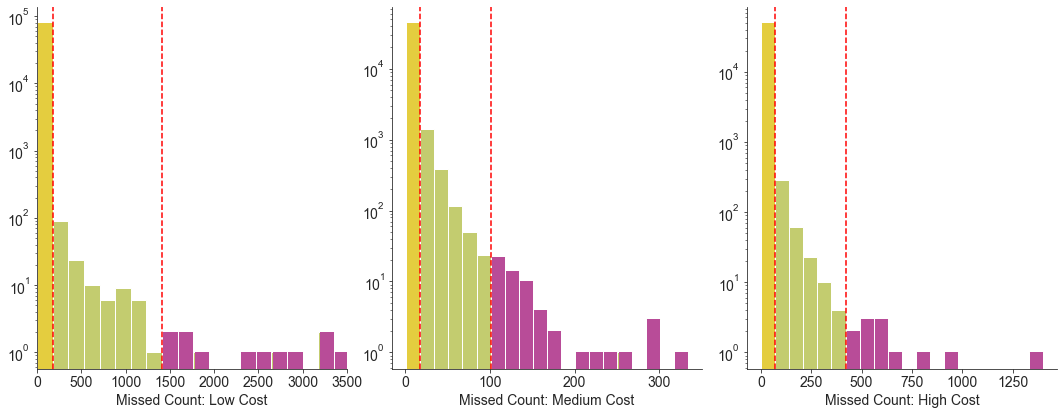

In [91]:
df5 = df3[df3.MissedCount>1].reset_index(drop=True)
        
plt.close()
fig = plt.figure(figsize=(15,6))

# low

df5_low = df5[df5.CostCategory=='low'].reset_index(drop=True)
counts, bins = np.histogram(df5_low.MissedCount, bins=20)
bins = bins[:len(counts)]
model = IsotonicRegression(increasing=False).fit(bins, counts)
yp = model.predict(bins)
kl = KneeLocator(bins, yp, curve="convex", direction="decreasing")
knee1 = kl.knee
ids = bins>knee1
kl = KneeLocator(bins[ids], yp[ids], curve="convex", direction="decreasing")
knee2 = knee1+kl.knee
print('\nlow')
print(f'cut point #1 = {knee1:.1f}, cut point #2 = {knee2:.1f}')
misseddemand = df5_low.MissedDemand[df5_low.MissedCount>knee2].sum()
print(f'missed demand = {misseddemand:.1f}')

ax = fig.add_subplot(131)
ax.hist(df5.MissedCount[df5.CostCategory=='low'], bins=20, color=color_green)
counts, bins = np.histogram(df5.MissedCount[df5.CostCategory=='low'], bins=20)
for bi in range(len(bins)-1):
    if bins[bi+1]<=knee1:
        color = color_yellow
    elif bins[bi]>=knee2-10:
        color = color_purple
    else:
        continue
    width = bins[bi+1]-bins[bi]
    ax.add_patch(Rectangle(
        xy=(bins[bi]+0.08*width, 0), width=0.92*width, height=counts[bi],
        facecolor=color, edgecolor='none'))
ax.axvline(knee1, c='r', ls='--')
ax.axvline(knee2, c='r', ls='--')
ax.set_xlabel('Missed Count: Low Cost')
plt.yscale('log', nonpositive='clip')
seaborn.despine()
#ax.set_ylim(0,1e5)
ax.set_xlim(0,3500)

df6 = df5_low.copy()
ids = df5_low.MissedCount>knee2
df6.loc[ids, 'MissedCount'] = knee2
df6.loc[ids, 'MissedDemand'] = knee2*df5_low.WholesaleCost[ids]
misseddemand2 = df6.MissedDemand[ids].sum()
diff_perc_misseddemand = (misseddemand-misseddemand2)/misseddemand*100
print(f'updated missed demand = {misseddemand2:.1f} (decreased by {diff_perc_misseddemand:.0f}%)')
df5.loc[df5.CostCategory=='low'] = df6.values


# medium

counts, bins = np.histogram(df5.MissedCount[df5.CostCategory=='medium'], bins=20)
bins = bins[:len(counts)]
model = IsotonicRegression(increasing=False).fit(bins, counts)
yp = model.predict(bins)
kl = KneeLocator(bins, yp, curve="convex", direction="decreasing")
knee1 = kl.knee
ids = bins>knee1
kl = KneeLocator(bins[ids], yp[ids], curve="convex", direction="decreasing")
knee2 = knee1+kl.knee

ax = fig.add_subplot(132)
ax.hist(df5.MissedCount[df5.CostCategory=='medium'], bins=20, color=color_green)
counts, bins = np.histogram(df5.MissedCount[df5.CostCategory=='medium'], bins=20)
for bi in range(len(bins)-1):
    if bins[bi+1]<=knee1:
        color = color_yellow
    elif bins[bi]>=knee2-10:
        color = color_purple
    else:
        continue
    width = bins[bi+1]-bins[bi]
    ax.add_patch(Rectangle(
        xy=(bins[bi]+0.08*width, 0), width=0.92*width, height=counts[bi],
        facecolor=color, edgecolor='none'))
ax.axvline(knee1, c='r', ls='--')
ax.axvline(knee2, c='r', ls='--')
ax.set_xlabel('Missed Count: Medium Cost')
plt.yscale('log', nonpositive='clip')
seaborn.despine()
#ax.set_ylim(0,1e5)
#ax.set_xlim(0,3500)

# high

df5_high = df5[df5.CostCategory=='high'].reset_index(drop=True)
counts, bins = np.histogram(df5_high.MissedCount, bins=20)
bins = bins[:len(counts)]
model = IsotonicRegression(increasing=False).fit(bins, counts)
yp = model.predict(bins)
kl = KneeLocator(bins, yp, curve="convex", direction="decreasing")
knee1 = kl.knee
ids = bins>knee1
kl = KneeLocator(bins[ids], yp[ids], curve="convex", direction="decreasing")
knee2 = knee1+kl.knee
print('\nhigh')
print(f'cut point #1 = {knee1:.1f}, cut point #2 = {knee2:.1f}')
misseddemand = df5_high.MissedDemand[df5_high.MissedCount>knee2].sum()
print(f'missed demand = {misseddemand:.1f}')

ax = fig.add_subplot(133)
ax.hist(df5.MissedCount[df5.CostCategory=='high'], bins=20, color=color_green)
counts, bins = np.histogram(df5.MissedCount[df5.CostCategory=='high'], bins=20)
for bi in range(len(bins)-1):
    if bins[bi+1]<=knee1:
        color = color_yellow
    elif bins[bi]>=knee2-10:
        color = color_purple
    else:
        continue
    width = bins[bi+1]-bins[bi]
    ax.add_patch(Rectangle(
        xy=(bins[bi]+0.08*width, 0), width=0.92*width, height=counts[bi],
        facecolor=color, edgecolor='none'))
ax.axvline(knee1, c='r', ls='--')
ax.axvline(knee2, c='r', ls='--')
ax.set_xlabel('Missed Count: High Cost')
plt.yscale('log', nonpositive='clip')
seaborn.despine()
#ax.set_ylim(0,1e5)
#ax.set_xlim(0,3500)

df6 = df5_high.copy()
ids = df5_high.MissedCount>knee2
df6.loc[ids, 'MissedCount'] = knee2
df6.loc[ids, 'MissedDemand'] = knee2*df5_high.WholesaleCost[ids]
misseddemand2 = df6.MissedDemand[ids].sum()
diff_perc_misseddemand = (misseddemand-misseddemand2)/misseddemand*100
print(f'updated missed demand = {misseddemand2:.1f} (decreased by {diff_perc_misseddemand:.0f}%)')
df5.loc[df5.CostCategory=='high'] = df6.values

plt.tight_layout()
plt.savefig(os.path.join(figure_path, 'missed_count_hist_by_cost_catgory.png'))

## validation

In [41]:
print(df5.MissedCount.sum())
print(df3.MissedCount.sum())
print(df5.MissedCount.sum() / df3.MissedCount.sum())

983011.3946972667
1211818.5456110337
0.8111869539029082


In [42]:
print(df5.MissedDemand.sum())
print(df3.MissedDemand.sum())
print(df5.MissedDemand.sum()/ df3.MissedDemand.sum())

113124007.04408175
151948175.40860325
0.7444907234975373


In [32]:
replenishmentdf5.to_csv(os.path.join(data_path, 'optimized pool.csv'), index=False)